In [1]:
import argparse
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Dataset
from torch.utils.tensorboard import SummaryWriter
from multiprocessing import cpu_count
from denoising_diffusion_pytorch.utils import *
from pathlib import Path
import torch
from torchvision import transforms as T, utils
from tqdm.auto import tqdm
import os
import re
from ema_pytorch import EMA
from denoising_diffusion_pytorch.inception_score_evaluation import InceptionScoreEvaluation
from denoising_diffusion_pytorch.fid_evaluation import FIDEvaluation
from torch.utils.data import DataLoader

/Users/laurabarseghyan/miniconda3/envs/diff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def create_mask(height=32, width=32, guided_region=(8, 24, 8, 24)):
    """
    Creates a binary mask for a 32x32 image.
    
    Parameters:
        height (int): Height of the mask.
        width (int): Width of the mask.
        guided_region (tuple): A tuple (top, bottom, left, right) that defines the region
                               where the mask is set to 0 (i.e. the area that will be replaced by the guide).
                               The rest of the image will have a value of 1.
                               
    Returns:
        mask (torch.Tensor): A tensor of shape (1, height, width) representing the binary mask.
    """
    # Start with a mask of ones (keep generated content)
    mask = torch.ones((height, width))
    
    # Define the region where we want to apply the guide (set these pixels to 0)
    top, bottom, left, right = guided_region
    mask[top:bottom, left:right] = 0.0
    
    # Optionally add a channel dimension (for broadcasting over image channels)
    mask = mask.unsqueeze(0)  # Shape: (1, 32, 32)
    return mask

In [3]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    dropout = 0.1,
)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000,           # number of steps
)


ema_decay = 0.995
ema_update_every = 10
ema = EMA(diffusion, beta = ema_decay, update_every = ema_update_every)

num_samples = 25
batch_size = 64
device = 'cpu'
inception_block_idx =2048  #from trainer
image_size = 32            #from trainer
training_images_folder = '../data/cifar-10/train_images'

In [4]:
# Use the command-line argument for ddim_sampling_timesteps
trained_models_folder = '../results/14-03-2025_models'
ddim_sampling_timesteps = 50
generation_results_folder = '../guided_test_gen'             # None
ddim_sampling = True
sampling_model = 4

In [5]:
# Find the model numbers
if sampling_model is not None:
    milestones = [sampling_model]
else:
    pattern = re.compile(r"model-(\d+)\.pt")
    milestones = []
    for filename in os.listdir(trained_models_folder):
        match = pattern.fullmatch(filename)
        if match:
            milestones.append(int(match.group(1)))
    milestones.sort() 

if generation_results_folder is not None:
    generation_results_folder = Path(generation_results_folder)
    generation_results_folder.mkdir(parents=True, exist_ok = True)
else:
    generation_results_folder = Path("./results_ddim")  / f"{os.path.basename(trained_models_folder)}_{ddim_sampling_timesteps}"

    counter = 1
    while generation_results_folder.exists():
        generation_results_folder = Path("./results_ddim") / f"{os.path.basename(trained_models_folder)}_{ddim_sampling_timesteps}_{counter}"
        counter += 1
    generation_results_folder.mkdir(parents=True, exist_ok=True)

In [6]:
# for milestone in milestones: 
#     data = torch.load(str(Path(trained_models_folder) / f'model-{milestone}.pt'), map_location=device, weights_only=True)
#     ema.load_state_dict(data["ema"])
#     ema.ema_model.eval()

#     (h, w), channels = ema.ema_model.image_size, ema.ema_model.channels

#     with torch.inference_mode():
#         batches = num_to_groups(num_samples, batch_size)
#         if ddim_sampling:
#             all_images_list = list(map(lambda n: ema.ema_model.ddim_sample((n, channels, h, w), sampling_timesteps = ddim_sampling_timesteps, return_all_timesteps = False), batches))     # if ddim
#         else:
#             all_images_list = list(map(lambda n: ema.ema_model.sample(batch_size=n), batches))    
        
#     all_images = torch.cat(all_images_list, dim = 0)
#     utils.save_image(all_images, str(generation_results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(num_samples)))

### Guided Sampling

##### Guide Image

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Specify the file path to your guide image (a single image file)
guide_image_path = '/Users/laurabarseghyan/Desktop/Capstone_Thesis/diffusion-models/results_ddim/accentor_ddim/accentor_s_000377.png'

# Choose the image mode based on the number of channels (e.g., 'RGB' for 3 channels)
convert_image_to = {1: 'L', 3: 'RGB', 4: 'RGBA'}.get(diffusion.channels)

# Define a transform to resize the image and convert it to a tensor.
# Adjust the transform as needed to match your model's expected input dimensions.
transform = T.Compose([
    T.Resize(image_size),         
    T.CenterCrop(image_size),      
    T.ToTensor(),                          
])

guide_image_pil = Image.open(guide_image_path).convert(convert_image_to)
guide_image = transform(guide_image_pil).unsqueeze(0).to(device)
guide_image = ema.ema_model.normalize(guide_image)



In [15]:
# Create a mask for the guided regions (for example, a binary mask for a 32x32 image)
mask = create_mask(guided_region=(0, 15, 0, 15)) 

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7102134..2.0730195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1441246..2.3447502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7102134..2.0730195].


time_next_cond:  tensor([999, 999, 999, 999, 999, 999, 999, 999, 999])


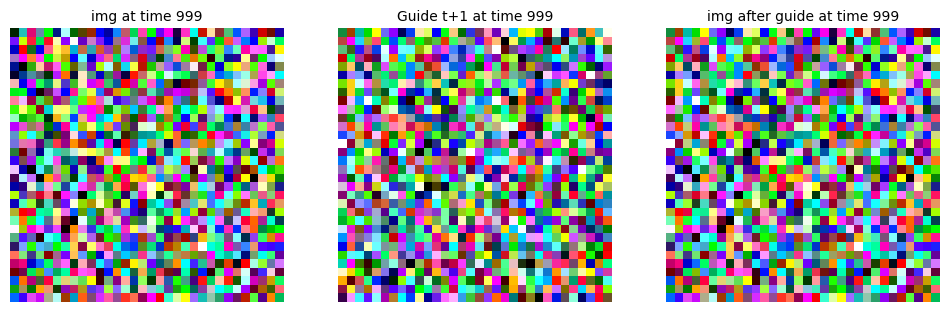

sampling loop time step:   2%|▏         | 1/50 [00:00<00:38,  1.27it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7219932..2.078341].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3015411..2.3646169].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7219932..2.078341].


time_next_cond:  tensor([979, 979, 979, 979, 979, 979, 979, 979, 979])


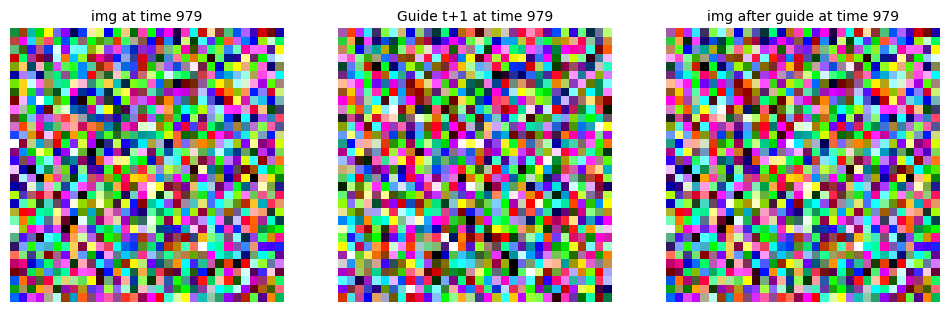

sampling loop time step:   4%|▍         | 2/50 [00:01<00:41,  1.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7321477..2.08357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3341469..2.1376019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7321477..2.08357].


time_next_cond:  tensor([959, 959, 959, 959, 959, 959, 959, 959, 959])


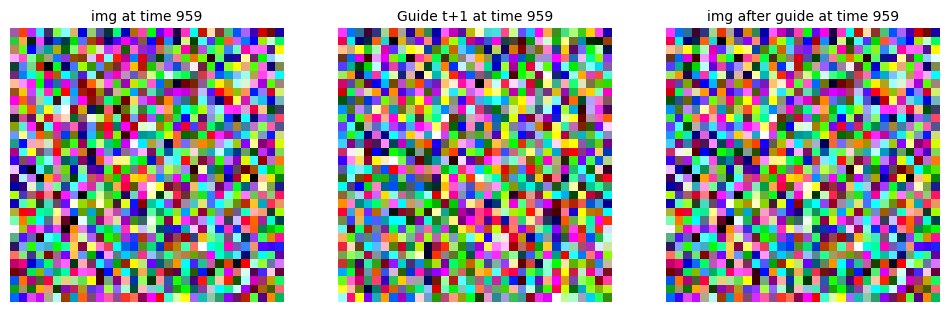

sampling loop time step:   6%|▌         | 3/50 [00:02<00:36,  1.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.741312..2.0864167].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0715195..2.200942].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.741312..2.0864167].


time_next_cond:  tensor([939, 939, 939, 939, 939, 939, 939, 939, 939])


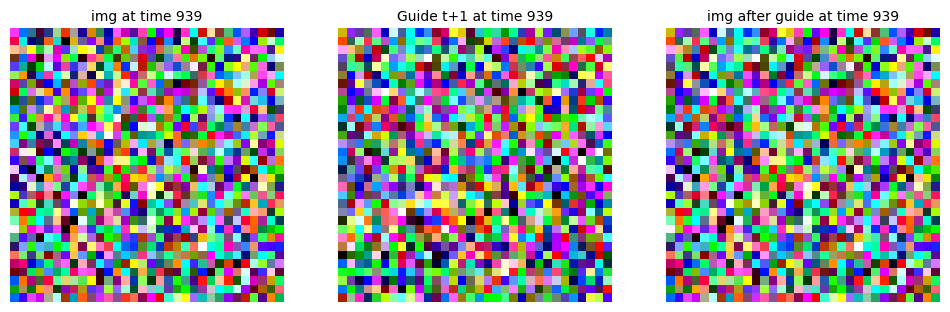

sampling loop time step:   8%|▊         | 4/50 [00:03<00:34,  1.35it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7495775..2.0886953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1991239..2.269414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7495775..2.269414].


time_next_cond:  tensor([919, 919, 919, 919, 919, 919, 919, 919, 919])


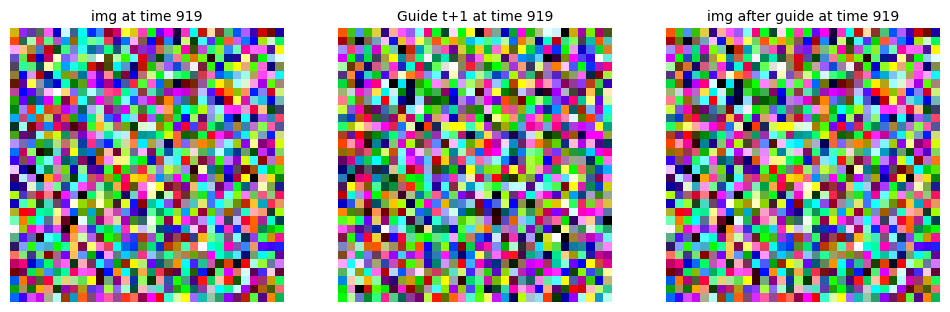

sampling loop time step:  10%|█         | 5/50 [00:03<00:31,  1.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7578602..2.2679334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1490161..2.193425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7578602..2.0894332].


time_next_cond:  tensor([899, 899, 899, 899, 899, 899, 899, 899, 899])


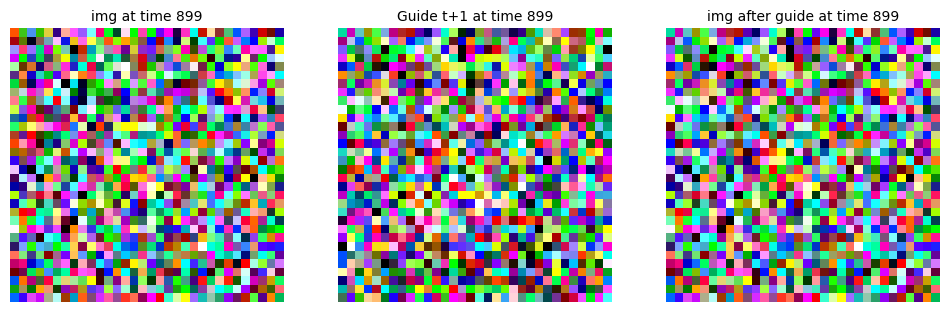

sampling loop time step:  12%|█▏        | 6/50 [00:04<00:29,  1.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7631178..2.0884771].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.227113..2.321042].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7631178..2.1066585].


time_next_cond:  tensor([879, 879, 879, 879, 879, 879, 879, 879, 879])


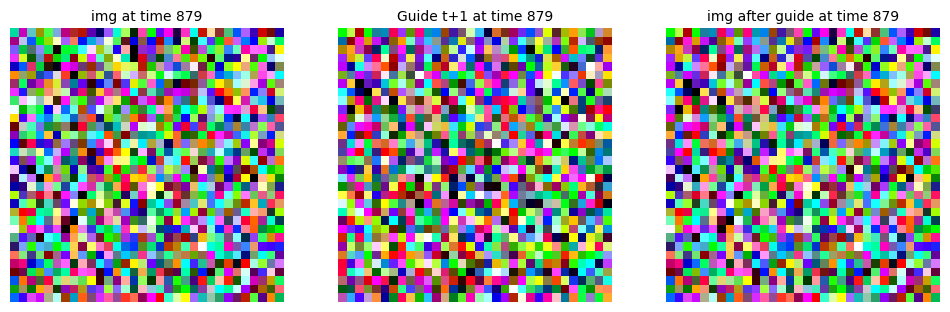

sampling loop time step:  14%|█▍        | 7/50 [00:04<00:27,  1.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7638903..2.1052637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3436888..2.4071448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7638903..2.0862012].


time_next_cond:  tensor([859, 859, 859, 859, 859, 859, 859, 859, 859])


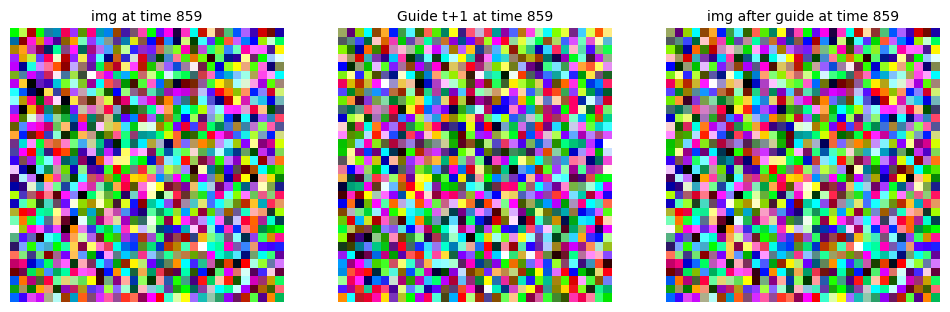

sampling loop time step:  16%|█▌        | 8/50 [00:05<00:29,  1.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7646091..2.0836627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3121341..2.2861667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7646091..2.0836627].


time_next_cond:  tensor([839, 839, 839, 839, 839, 839, 839, 839, 839])


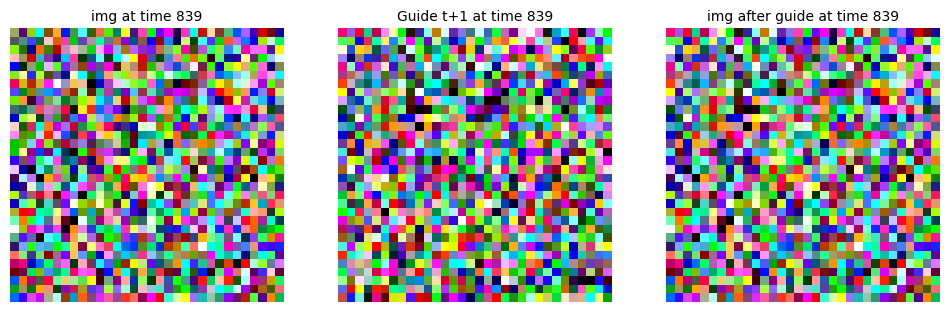

sampling loop time step:  18%|█▊        | 9/50 [00:06<00:27,  1.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7650132..2.0816388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2196096..2.3000703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7650132..2.3000703].


time_next_cond:  tensor([819, 819, 819, 819, 819, 819, 819, 819, 819])


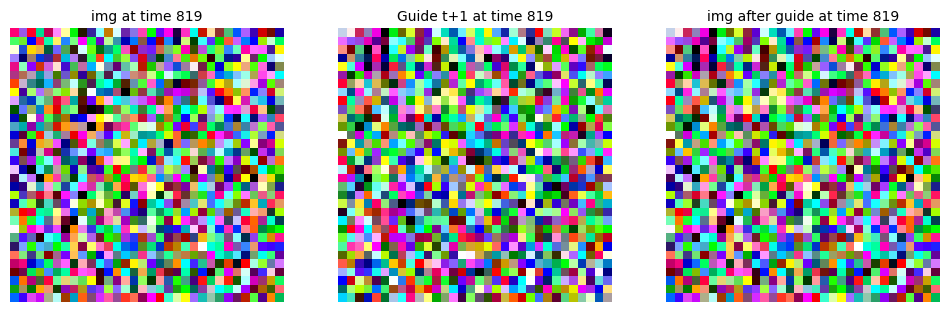

sampling loop time step:  20%|██        | 10/50 [00:06<00:25,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7611198..2.298018].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0557469..2.3013923].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7611198..2.2787395].


time_next_cond:  tensor([799, 799, 799, 799, 799, 799, 799, 799, 799])


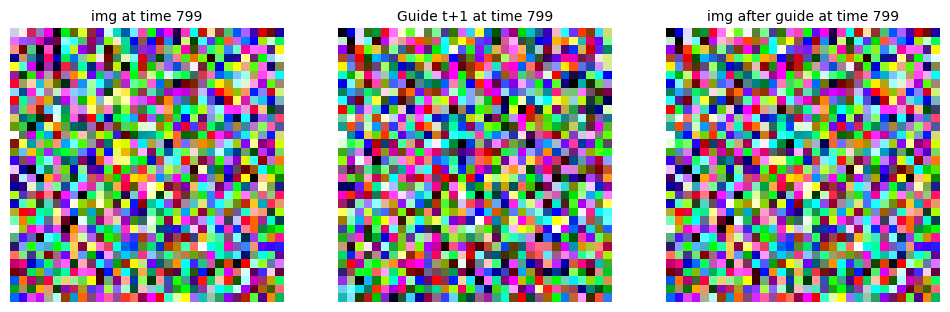

sampling loop time step:  22%|██▏       | 11/50 [00:07<00:24,  1.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7571297..2.2774441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1036228..2.152928].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7571297..2.152928].


time_next_cond:  tensor([779, 779, 779, 779, 779, 779, 779, 779, 779])


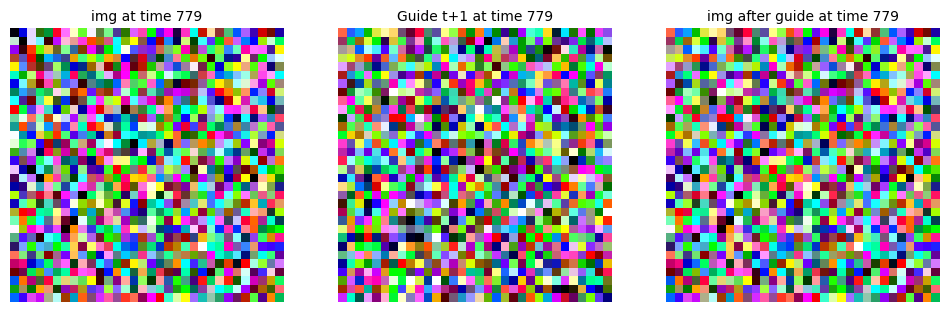

sampling loop time step:  24%|██▍       | 12/50 [00:08<00:23,  1.59it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7520769..2.151767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1841509..2.4815173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7520769..2.0750353].


time_next_cond:  tensor([759, 759, 759, 759, 759, 759, 759, 759, 759])


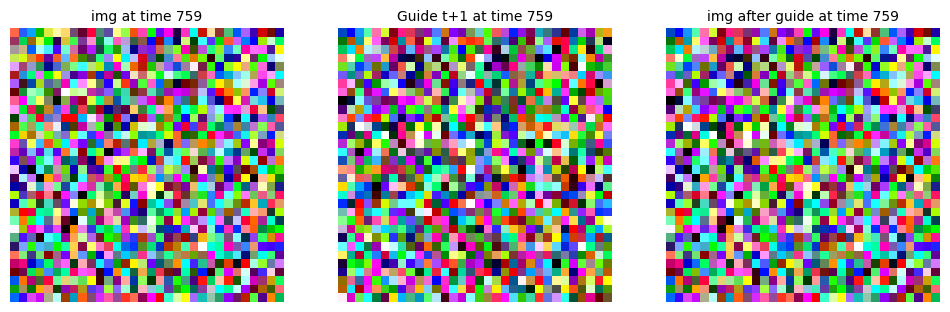

sampling loop time step:  26%|██▌       | 13/50 [00:08<00:23,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7484541..2.0728402].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2827756..2.1119814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7484541..2.0728402].


time_next_cond:  tensor([739, 739, 739, 739, 739, 739, 739, 739, 739])


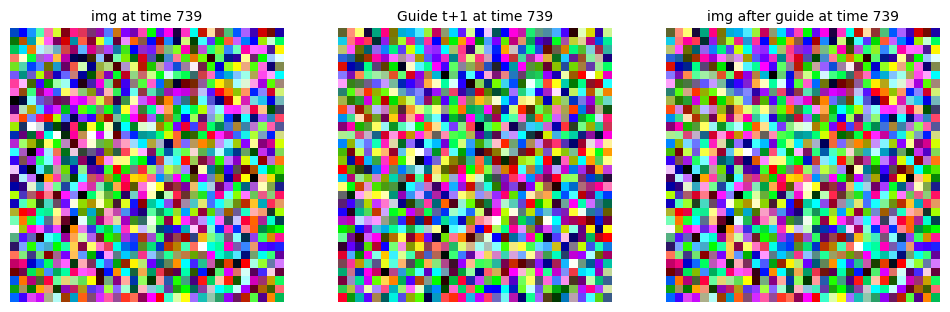

sampling loop time step:  28%|██▊       | 14/50 [00:09<00:22,  1.61it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7428043..2.0708098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2024186..2.3461142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7428043..2.0708098].


time_next_cond:  tensor([719, 719, 719, 719, 719, 719, 719, 719, 719])


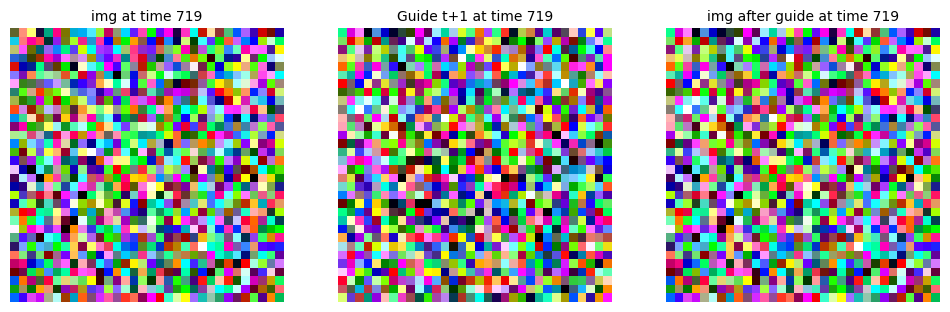

sampling loop time step:  30%|███       | 15/50 [00:09<00:21,  1.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7375515..2.0686302].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0153447..2.0046751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7375515..2.0686302].


time_next_cond:  tensor([699, 699, 699, 699, 699, 699, 699, 699, 699])


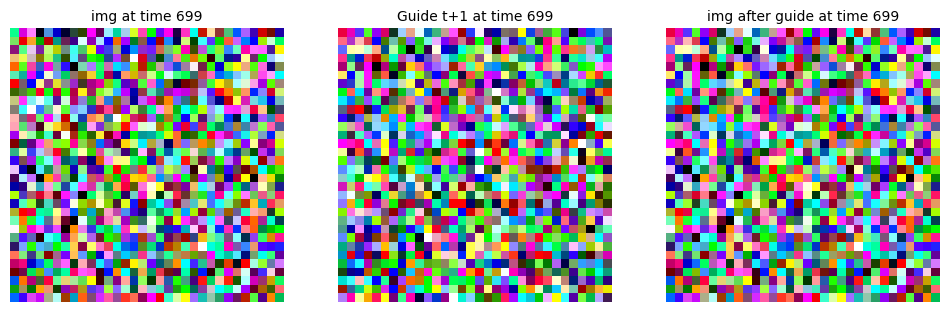

sampling loop time step:  32%|███▏      | 16/50 [00:10<00:21,  1.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7303264..2.0656419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3290635..1.9896814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7303264..2.0656419].


time_next_cond:  tensor([679, 679, 679, 679, 679, 679, 679, 679, 679])


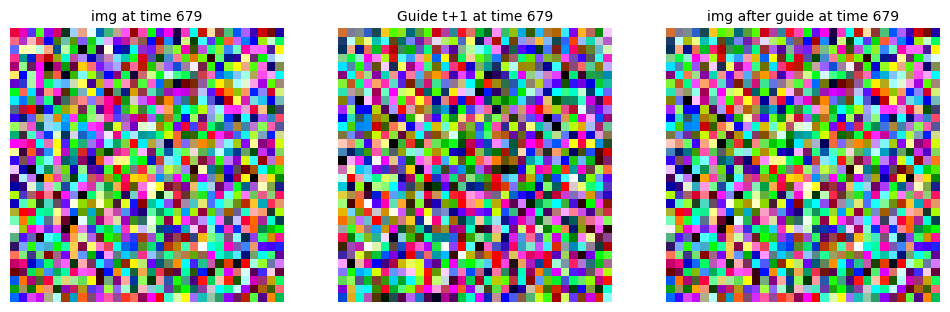

sampling loop time step:  34%|███▍      | 17/50 [00:11<00:20,  1.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7224221..2.0618386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.288127..2.2373762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7224221..2.1933284].


time_next_cond:  tensor([659, 659, 659, 659, 659, 659, 659, 659, 659])


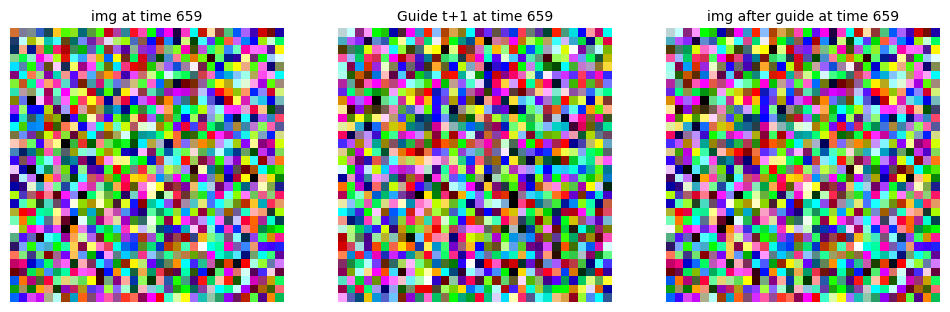

sampling loop time step:  36%|███▌      | 18/50 [00:11<00:19,  1.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7142496..2.1896052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1569837..2.46496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7142496..2.46496].


time_next_cond:  tensor([639, 639, 639, 639, 639, 639, 639, 639, 639])


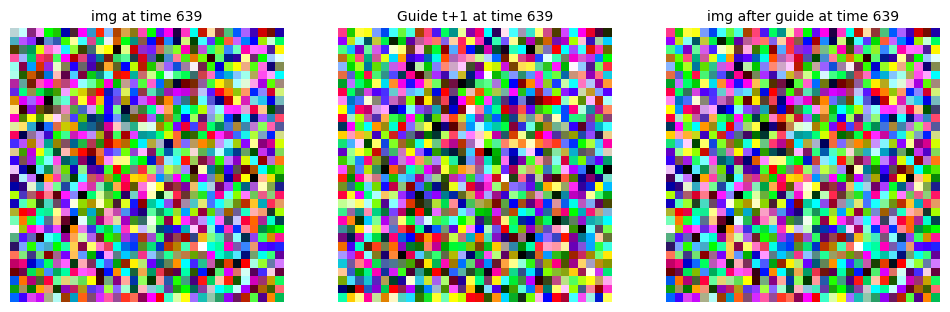

sampling loop time step:  38%|███▊      | 19/50 [00:12<00:20,  1.51it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.703114..2.4596329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4266406..2.1579123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.703114..2.1579123].


time_next_cond:  tensor([619, 619, 619, 619, 619, 619, 619, 619, 619])


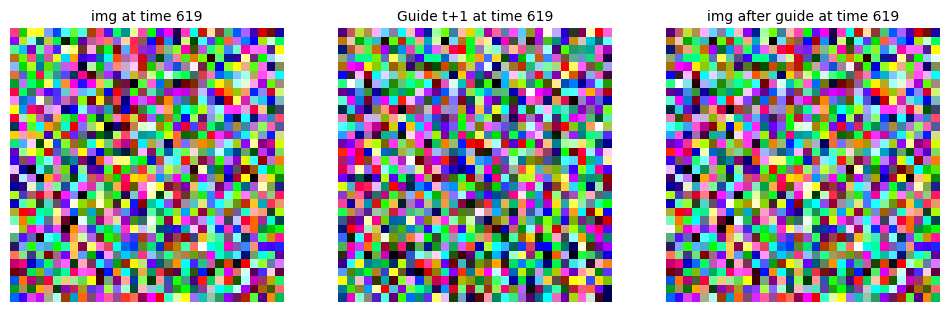

sampling loop time step:  40%|████      | 20/50 [00:13<00:19,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6919005..2.1510425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5942485..2.1592174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6919005..2.0476823].


time_next_cond:  tensor([599, 599, 599, 599, 599, 599, 599, 599, 599])


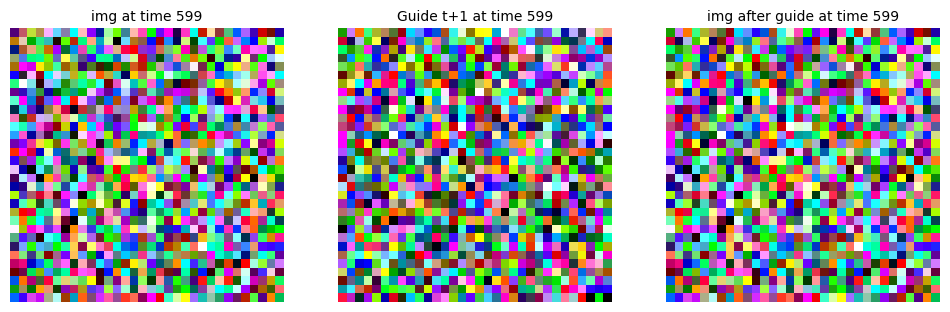

sampling loop time step:  42%|████▏     | 21/50 [00:14<00:20,  1.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6811645..2.0410867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1564994..2.2907279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6811645..2.0517564].


time_next_cond:  tensor([579, 579, 579, 579, 579, 579, 579, 579, 579])


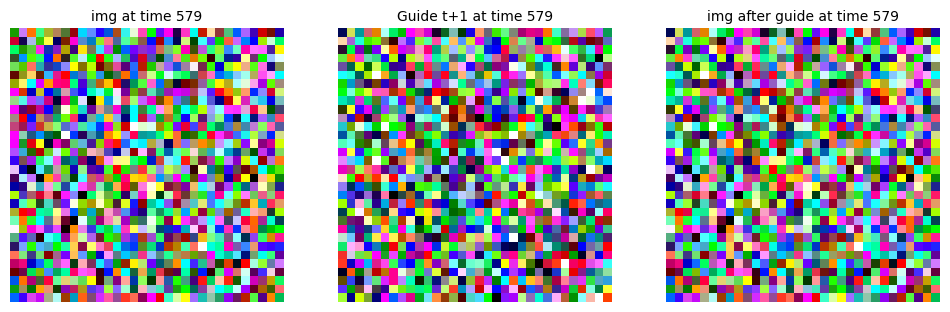

sampling loop time step:  44%|████▍     | 22/50 [00:14<00:18,  1.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.665915..2.0419788].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3933812..2.2771554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.665915..2.0625238].


time_next_cond:  tensor([559, 559, 559, 559, 559, 559, 559, 559, 559])


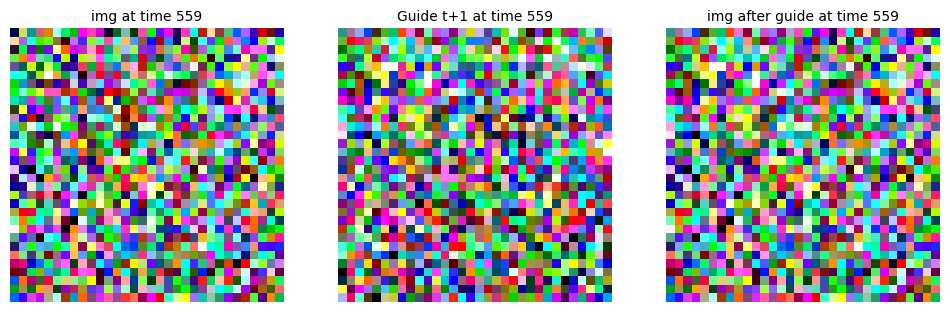

sampling loop time step:  46%|████▌     | 23/50 [00:15<00:17,  1.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6472497..2.0581596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1898074..2.0810337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6472497..2.028187].


time_next_cond:  tensor([539, 539, 539, 539, 539, 539, 539, 539, 539])


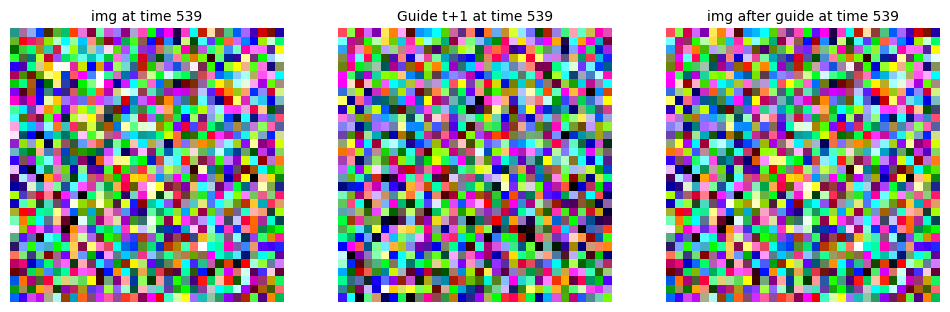

sampling loop time step:  48%|████▊     | 24/50 [00:15<00:16,  1.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6260428..2.0168295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1944185..2.5421135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6260428..2.3623068].


time_next_cond:  tensor([519, 519, 519, 519, 519, 519, 519, 519, 519])


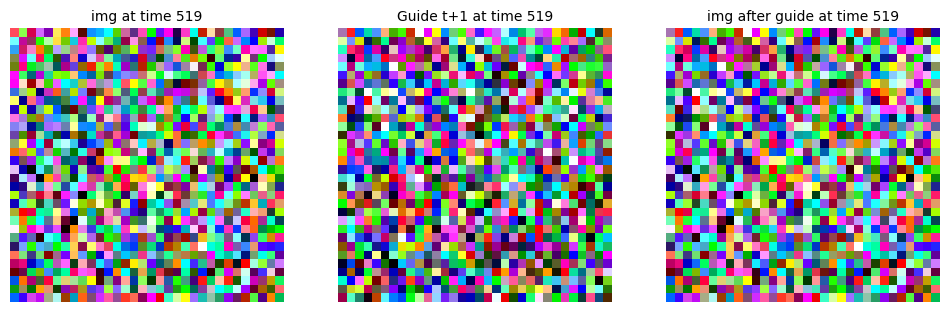

sampling loop time step:  50%|█████     | 25/50 [00:16<00:16,  1.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6038315..2.3511968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1620901..2.2777815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6038315..2.2777815].


time_next_cond:  tensor([499, 499, 499, 499, 499, 499, 499, 499, 499])


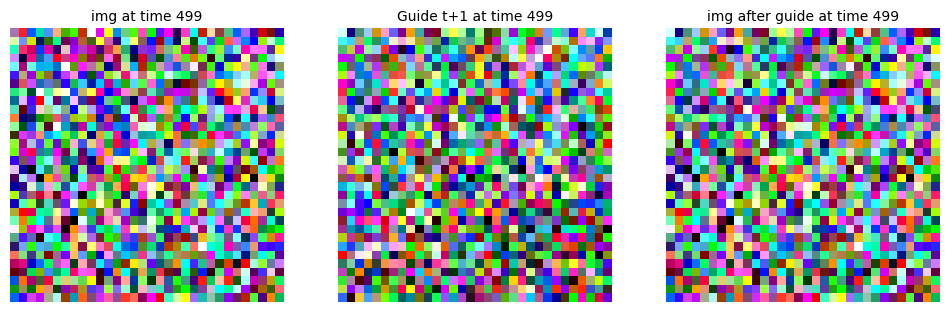

sampling loop time step:  52%|█████▏    | 26/50 [00:17<00:15,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5757899..2.2642953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.175559..2.0312822].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5757899..1.9856297].


time_next_cond:  tensor([479, 479, 479, 479, 479, 479, 479, 479, 479])


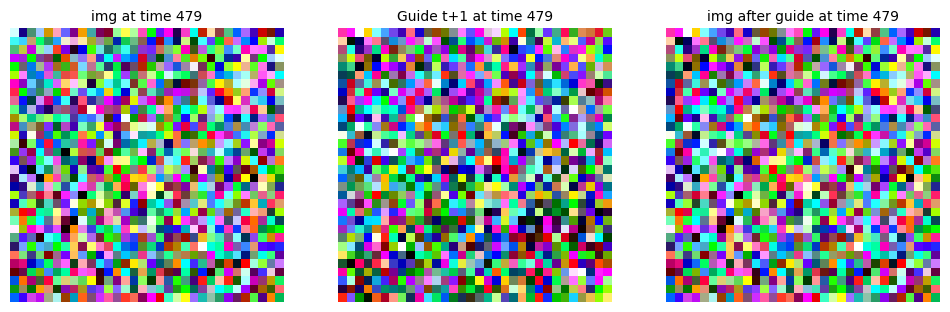

sampling loop time step:  54%|█████▍    | 27/50 [00:17<00:14,  1.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5469353..1.9685633].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1448586..2.4597023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5469353..2.4597023].


time_next_cond:  tensor([459, 459, 459, 459, 459, 459, 459, 459, 459])


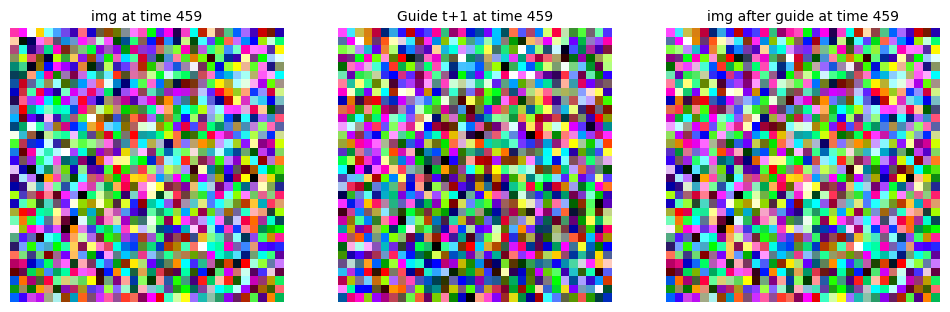

sampling loop time step:  56%|█████▌    | 28/50 [00:18<00:13,  1.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.511375..2.4366665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2658315..2.2826755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.511375..2.2826755].


time_next_cond:  tensor([439, 439, 439, 439, 439, 439, 439, 439, 439])


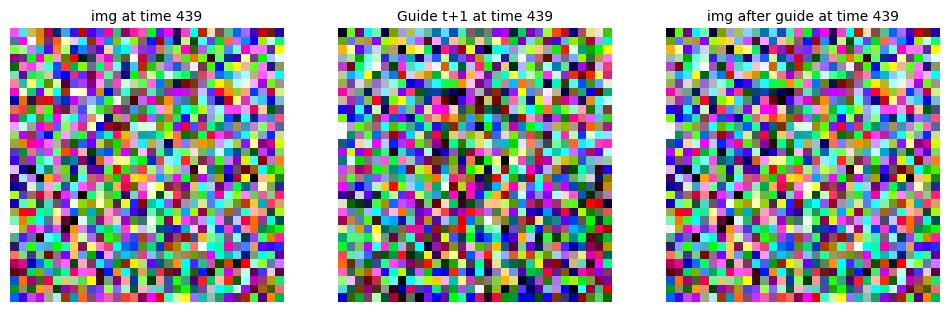

sampling loop time step:  58%|█████▊    | 29/50 [00:19<00:13,  1.59it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.470963..2.2493346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.919778..1.9712093].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.470963..1.9712093].


time_next_cond:  tensor([419, 419, 419, 419, 419, 419, 419, 419, 419])


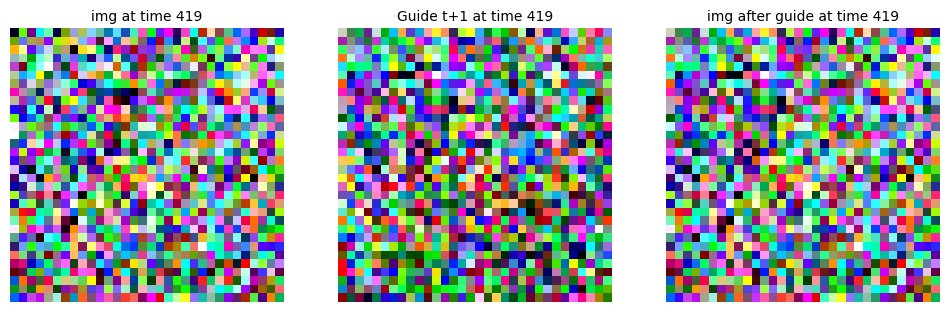

sampling loop time step:  60%|██████    | 30/50 [00:19<00:12,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4269481..1.9360002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0219464..2.0269263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4269481..1.9776912].


time_next_cond:  tensor([399, 399, 399, 399, 399, 399, 399, 399, 399])


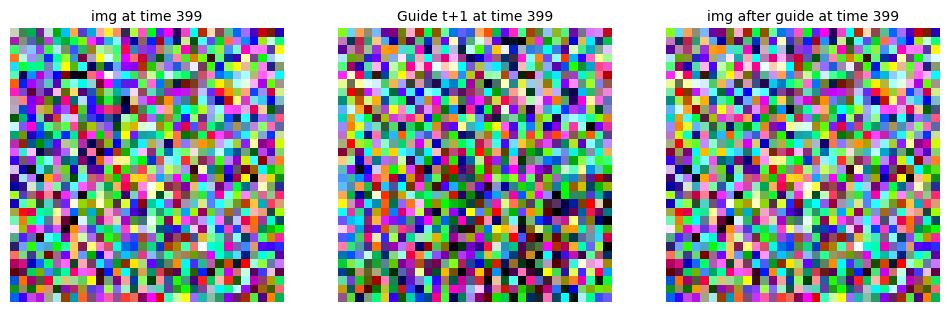

sampling loop time step:  62%|██████▏   | 31/50 [00:20<00:11,  1.61it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3754139..1.94732].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0862348..2.1016479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3754139..1.9463887].


time_next_cond:  tensor([379, 379, 379, 379, 379, 379, 379, 379, 379])


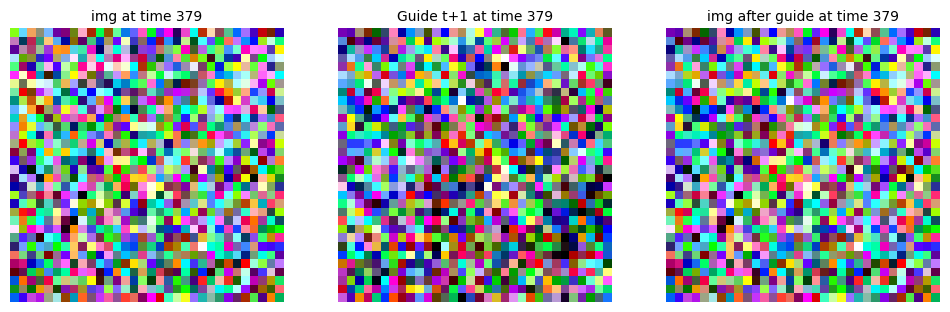

sampling loop time step:  64%|██████▍   | 32/50 [00:20<00:11,  1.61it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3211135..1.9136499].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8906524..1.9681084].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3211135..1.8652275].


time_next_cond:  tensor([359, 359, 359, 359, 359, 359, 359, 359, 359])


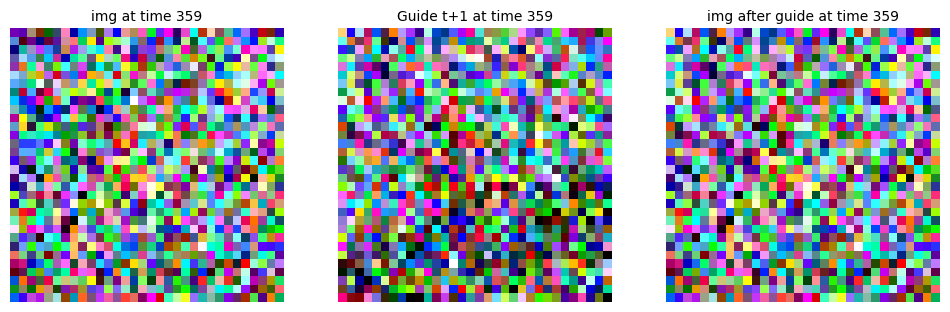

sampling loop time step:  66%|██████▌   | 33/50 [00:21<00:10,  1.61it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2599714..1.8343891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0365762..1.9358699].


time_next_cond:  tensor([339, 339, 339, 339, 339, 339, 339, 339, 339])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2599714..1.804563].


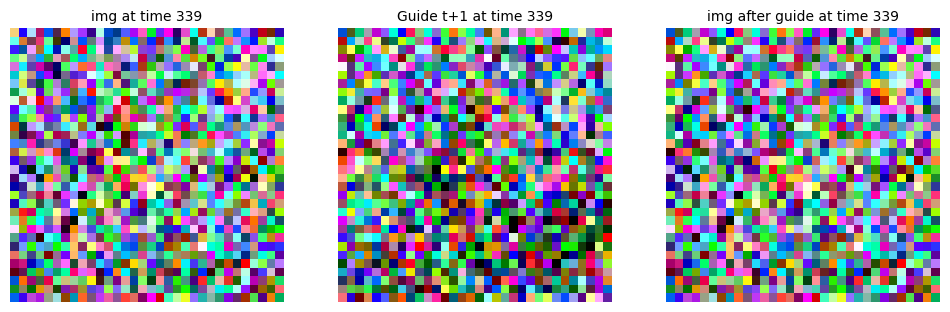

sampling loop time step:  68%|██████▊   | 34/50 [00:22<00:10,  1.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.191574..1.7642082].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2398281..1.9066664].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.191574..1.8967428].


time_next_cond:  tensor([319, 319, 319, 319, 319, 319, 319, 319, 319])


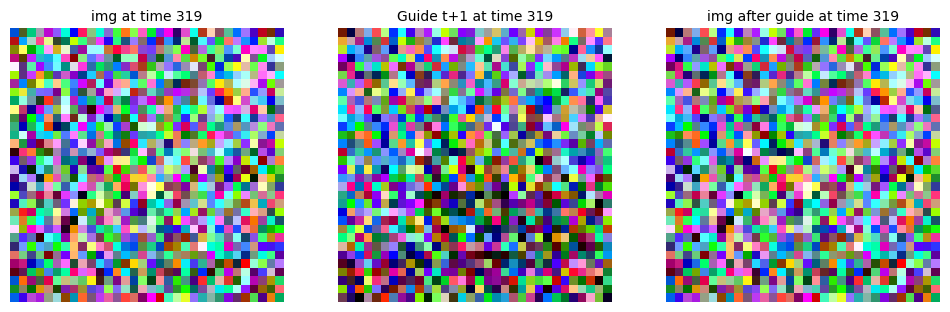

sampling loop time step:  70%|███████   | 35/50 [00:22<00:09,  1.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1183434..1.8495644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.786808..1.7595378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1183434..1.7420236].


time_next_cond:  tensor([299, 299, 299, 299, 299, 299, 299, 299, 299])


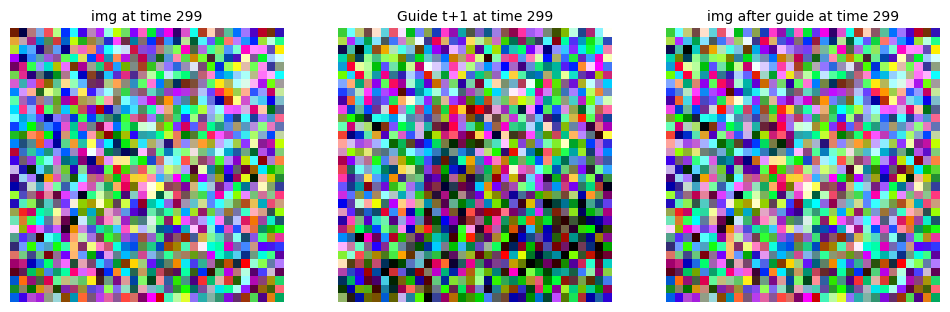

sampling loop time step:  72%|███████▏  | 36/50 [00:23<00:08,  1.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0365654..1.6885418].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94203377..2.0419474].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0365654..1.6896839].


time_next_cond:  tensor([279, 279, 279, 279, 279, 279, 279, 279, 279])


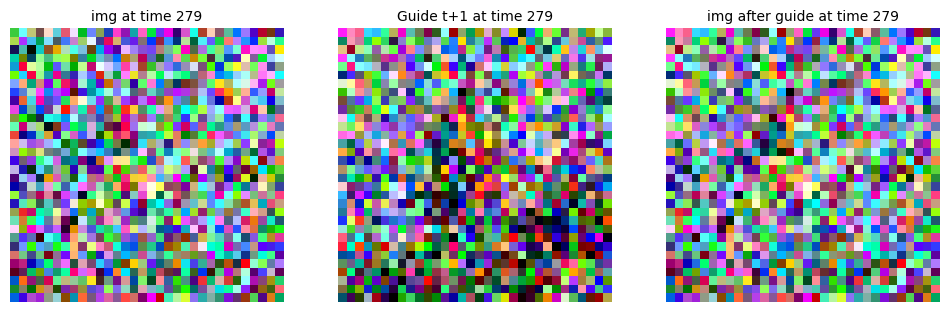

sampling loop time step:  74%|███████▍  | 37/50 [00:24<00:08,  1.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94885314..1.6415782].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91865754..1.6312053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94885314..1.6312053].


time_next_cond:  tensor([259, 259, 259, 259, 259, 259, 259, 259, 259])


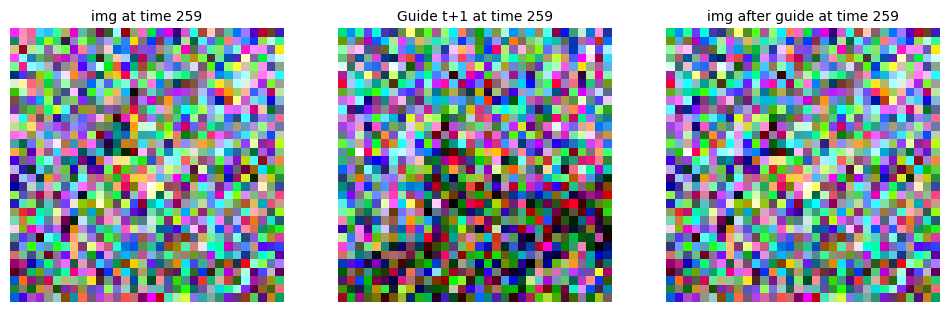

sampling loop time step:  76%|███████▌  | 38/50 [00:24<00:07,  1.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8536519..1.5818346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8935994..1.6055437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8536519..1.6055437].


time_next_cond:  tensor([239, 239, 239, 239, 239, 239, 239, 239, 239])


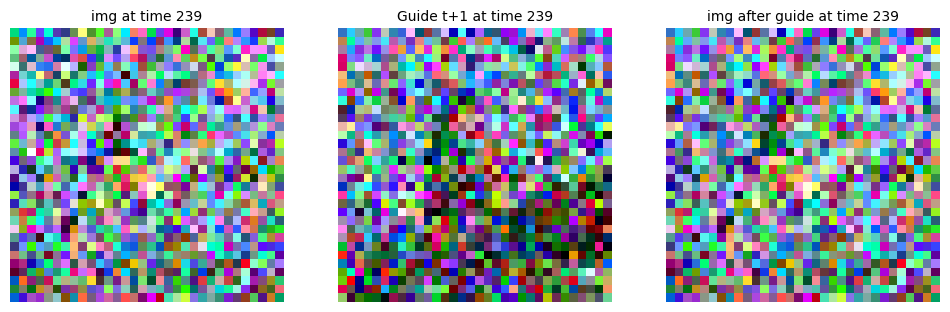

sampling loop time step:  78%|███████▊  | 39/50 [00:25<00:06,  1.59it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7528758..1.5453572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6517906..1.723861].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7528758..1.5297034].


time_next_cond:  tensor([219, 219, 219, 219, 219, 219, 219, 219, 219])


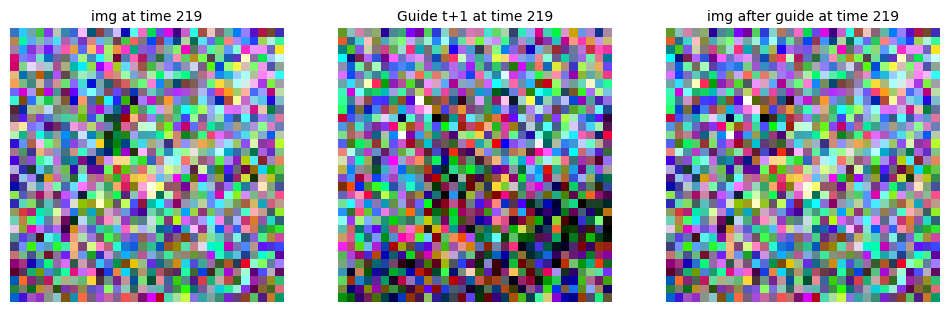

sampling loop time step:  80%|████████  | 40/50 [00:26<00:06,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64655125..1.4741714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0557791..1.6303875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64655125..1.6101635].


time_next_cond:  tensor([199, 199, 199, 199, 199, 199, 199, 199, 199])


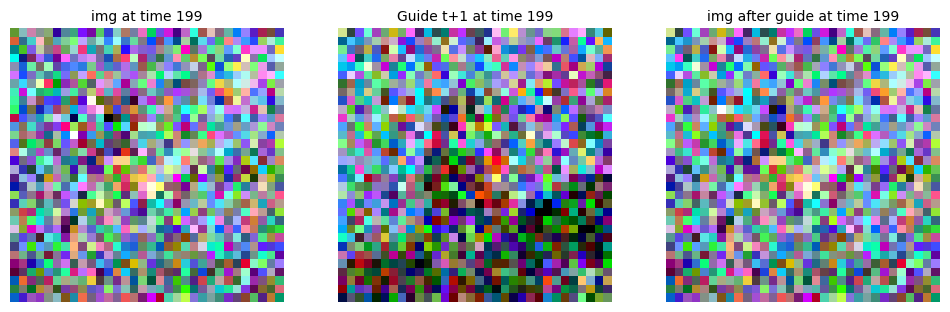

sampling loop time step:  82%|████████▏ | 41/50 [00:26<00:05,  1.59it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5338063..1.5305679].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8071296..1.4766705].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5338063..1.4766705].


time_next_cond:  tensor([179, 179, 179, 179, 179, 179, 179, 179, 179])


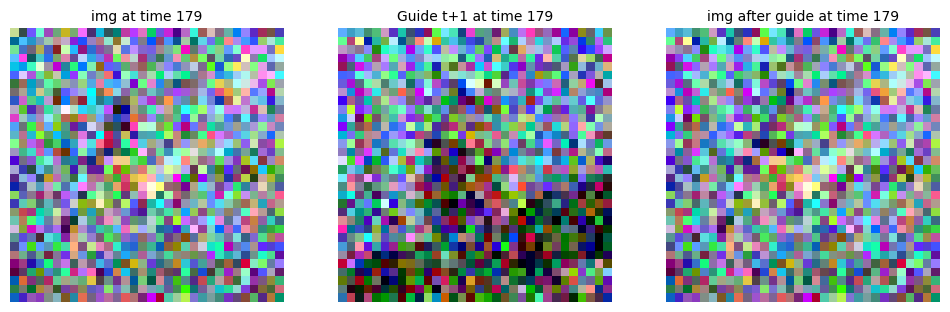

sampling loop time step:  84%|████████▍ | 42/50 [00:27<00:05,  1.59it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4161871..1.399795].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47833478..1.3419665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4161871..1.3531857].


time_next_cond:  tensor([159, 159, 159, 159, 159, 159, 159, 159, 159])


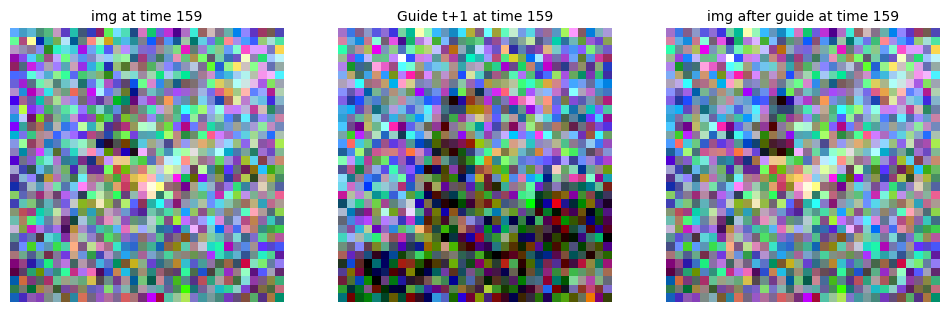

sampling loop time step:  86%|████████▌ | 43/50 [00:27<00:04,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29471332..1.2880646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7553375..1.3243946].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29471332..1.3243946].


time_next_cond:  tensor([139, 139, 139, 139, 139, 139, 139, 139, 139])


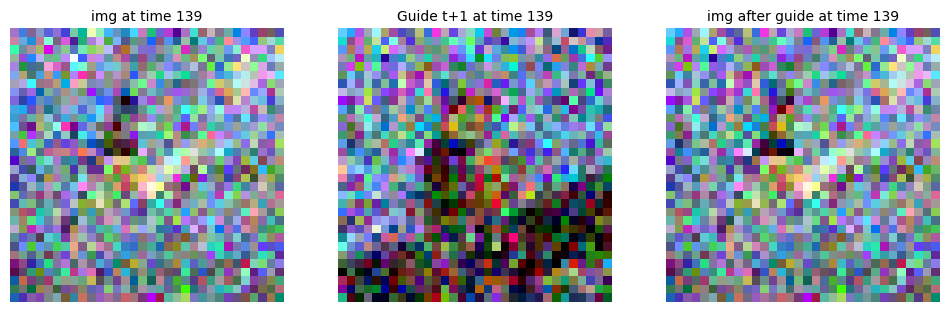

sampling loop time step:  88%|████████▊ | 44/50 [00:28<00:03,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16810852..1.2337112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51813483..1.32987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2970078..1.32987].


time_next_cond:  tensor([119, 119, 119, 119, 119, 119, 119, 119, 119])


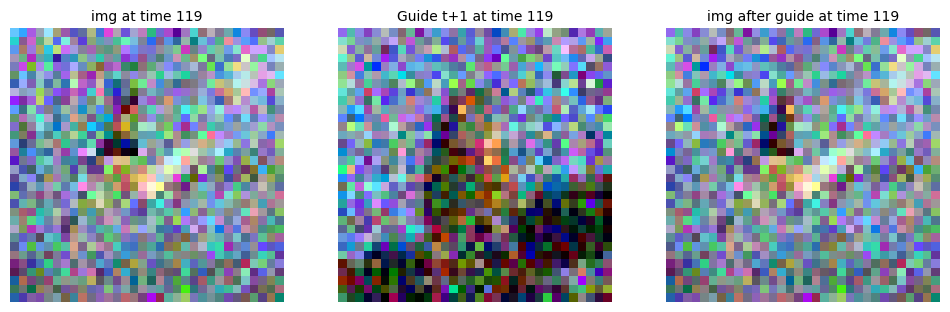

sampling loop time step:  90%|█████████ | 45/50 [00:29<00:03,  1.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2260428..1.2218493].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27115822..1.2007384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14297813..1.2007384].


time_next_cond:  tensor([99, 99, 99, 99, 99, 99, 99, 99, 99])


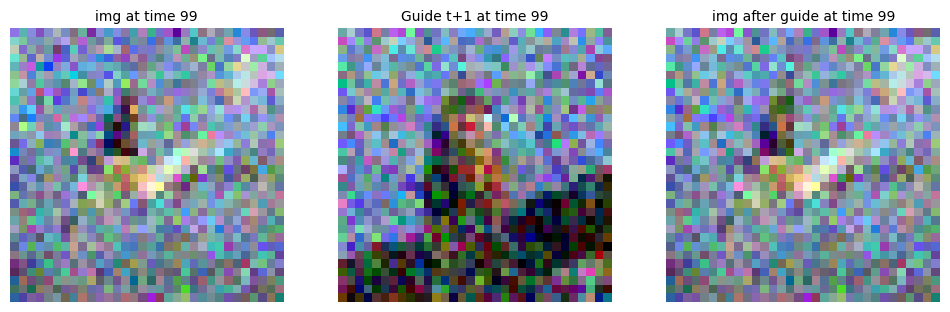

sampling loop time step:  92%|█████████▏| 46/50 [00:29<00:02,  1.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.074765205..1.1022424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2943734..1.1510432].


time_next_cond:  tensor([79, 79, 79, 79, 79, 79, 79, 79, 79])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056420684..1.110101].


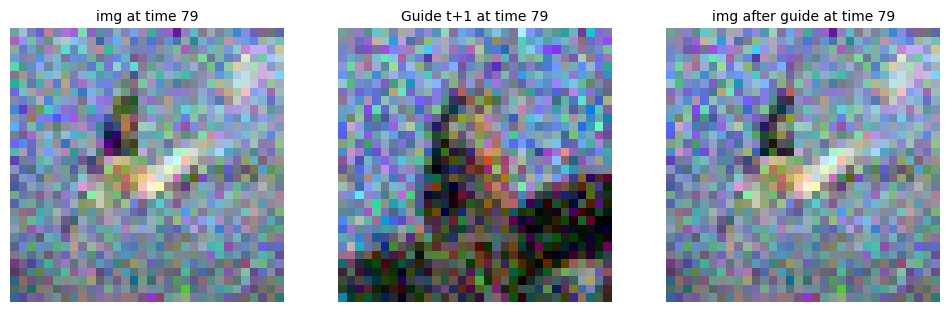

sampling loop time step:  94%|█████████▍| 47/50 [00:30<00:02,  1.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005489111..1.0366054].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21684343..1.0452037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035695314..1.0452037].


time_next_cond:  tensor([59, 59, 59, 59, 59, 59, 59, 59, 59])


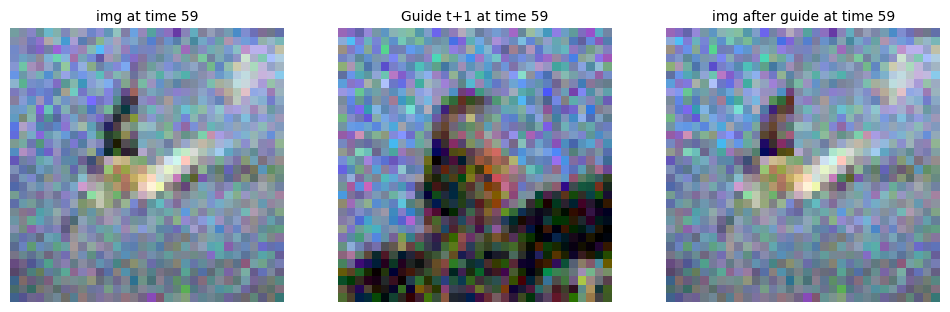

sampling loop time step:  96%|█████████▌| 48/50 [00:31<00:01,  1.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04399064..1.006291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15325242..0.95595706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015383035..1.006291].


time_next_cond:  tensor([39, 39, 39, 39, 39, 39, 39, 39, 39])


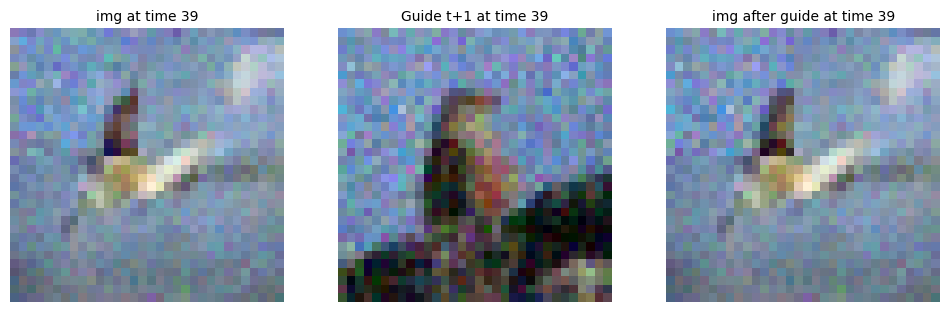

sampling loop time step: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


In [17]:
import matplotlib.pyplot as plt
for milestone in milestones: 
    data = torch.load(str(Path(trained_models_folder) / f'model-{milestone}.pt'), map_location=device, weights_only=True)
    ema.load_state_dict(data["ema"])
    ema.ema_model.eval()


    (h, w), channels = ema.ema_model.image_size, ema.ema_model.channels

    with torch.inference_mode():

        # Now, instead of creating a DataLoader to cycle through multiple images,
        # use the single guide_image directly in the guided sampling.
        batches = num_to_groups(9, batch_size)
        if ddim_sampling:
            all_images_list_guided = list(map(lambda n: ema.ema_model.ddim_sample_guided(
                (n, channels, h, w), 
                sampling_timesteps = ddim_sampling_timesteps, 
                guide=guide_image, 
                mask = mask
            ), batches))     # if ddim


    all_images_guided = torch.cat(all_images_list_guided, dim = 0)
    utils.save_image(all_images_guided, str(generation_results_folder / f'test-guided-sample-{milestone}-{ddim_sampling_timesteps}timesteps.png'), nrow = int(math.sqrt(9)))
